In [2]:
import os

carpetasN = ["InformativeSigns-01","RegulatorySigns-02","WarningSigns-03"]
TiposDeSenales = []

# Obtener todos los nombres de las carpetas de los tipos de señales
for a in carpetasN:
    nombres = os.listdir(a)
    TiposDeSenales.extend(nombres)


def getSignalDir(i:int):
    return carpetasN[int(TiposDeSenales[i][1])-1] +'/'+ TiposDeSenales[i]

def getSignalLis(i:int):
    return os.listdir(getSignalDir(i))


for i, b in enumerate(TiposDeSenales):
    print(TiposDeSenales[i],":  ",len(getSignalDir(i)))



0101-Parada_De_Bus :   38
0102-Zona_De_Encuentro :   42
0201-No_Pase :   31
0202-No_Parqueo :   34
0203-Pare :   28
0204-No_Girar_U :   34
0205-Prohibido_Parquear :   42
0206-Ceda_El_Paso :   36
0207-Prohibido_Girar_Derecha :   47
0208-Prohibido_Girar_Izquierda :   49
0209-Un_Solo_Sentido :   39
0210-Deteccion_Electronica :   45
0211-Prohibido_Dejar_Pasajeros :   49
0212-Velocidad_Maxima :   40
0213-Maltrato_Animal :   39
0214-No_Parqueo_Deteccion :   44
0301-Arroyo :   27
0302-Tráfico_Bicicletas :   39
0303-Zona_De_Peatones :   37
0304-Reductor_De_Velocidad :   42
0305-Zona_Escolar :   33


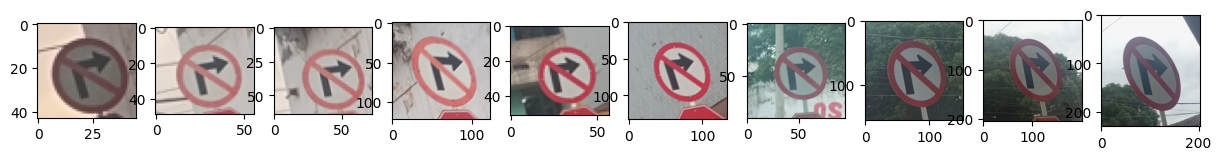

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

plt.figure(figsize=(15,15))


imagenes = getSignalLis(8)

for i , nombreimg in enumerate(imagenes[:10]):
  plt.subplot(1,10,i+1)
  img = mping.imread(getSignalDir(8) + "/" + nombreimg)
  plt.imshow(img)


In [4]:
import shutil

for i in range(len(TiposDeSenales)):
    imagenes = getSignalLis(i)

    if len(imagenes) < 20:
        print("Imagenes Insuficientes: " + TiposDeSenales[i] + " -> " + str(len(imagenes)))
        continue
    
    for j, nombreimg in enumerate(imagenes):

        directorio = "train/" + TiposDeSenales[i][:2] + TiposDeSenales[i][2:4]

        os.makedirs(directorio, exist_ok=True)
        shutil.copy(getSignalDir(i) + "/" + nombreimg, directorio)

Imagenes Insuficientes: 0201-No_Pase -> 8
Imagenes Insuficientes: 0209-Un_Solo_Sentido -> 2
Imagenes Insuficientes: 0211-Prohibido_Dejar_Pasajeros -> 12
Imagenes Insuficientes: 0212-Velocidad_Maxima -> 6
Imagenes Insuficientes: 0301-Arroyo -> 7
Imagenes Insuficientes: 0304-Reductor_De_Velocidad -> 12


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 15,
    zoom_range = [0.5, 1.15],
    validation_split = 0.3,
)

dataGenEntrenamiento = datagen.flow_from_directory( 'train', target_size = (224,224), batch_size = 32, shuffle = True, subset = "training")
dataGenValidacion = datagen.flow_from_directory( 'train', target_size = (224,224), batch_size = 32, shuffle = True, subset = "validation")

Found 1484 images belonging to 15 classes.
Found 628 images belonging to 15 classes.


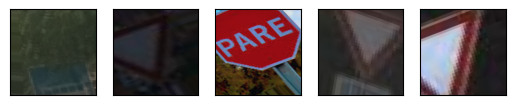

In [6]:
import matplotlib.pyplot as plt
for imagen, etiqueta in dataGenEntrenamiento:
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break

  plt.show()

In [7]:
import tensorflow as tf
# Cargar el modelo MobileNetV2 preentrenado de TensorFlow
mobilenetv2_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
mobilenetv2_base.trainable = False

# Definir la entrada
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pasar la entrada a través del modelo base
x = mobilenetv2_base(inputs, training=False)

# Añadir una capa de aplanamiento
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Añadir la capa final
outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

# Crear el modelo funcional
modelo = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# %%
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
epocas = 50

historial = modelo.fit(
  dataGenEntrenamiento, epochs = epocas, batch_size = 32,
    validation_data = dataGenValidacion
)

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 752ms/step - accuracy: 0.6800 - loss: 1.2590 - val_accuracy: 0.8742 - val_loss: 0.4586
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 708ms/step - accuracy: 0.8860 - loss: 0.3946 - val_accuracy: 0.9156 - val_loss: 0.3354
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 722ms/step - accuracy: 0.9081 - loss: 0.2861 - val_accuracy: 0.9331 - val_loss: 0.2514
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 708ms/step - accuracy: 0.9444 - loss: 0.1931 - val_accuracy: 0.9347 - val_loss: 0.2360
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 760ms/step - accuracy: 0.9558 - loss: 0.1639 - val_accuracy: 0.9395 - val_loss: 0.2209
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 768ms/step - accuracy: 0.9613 - loss: 0.1331 - val_accuracy: 0.9506 - val_loss: 0.2073
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 735ms/step - accuracy: 0.9653 - loss: 0.1174 - val_accuracy: 0.9506 - val_loss: 0.1560
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 734ms/step - accuracy: 0.9557 - loss: 0.1178 - val_accuracy: 0.937

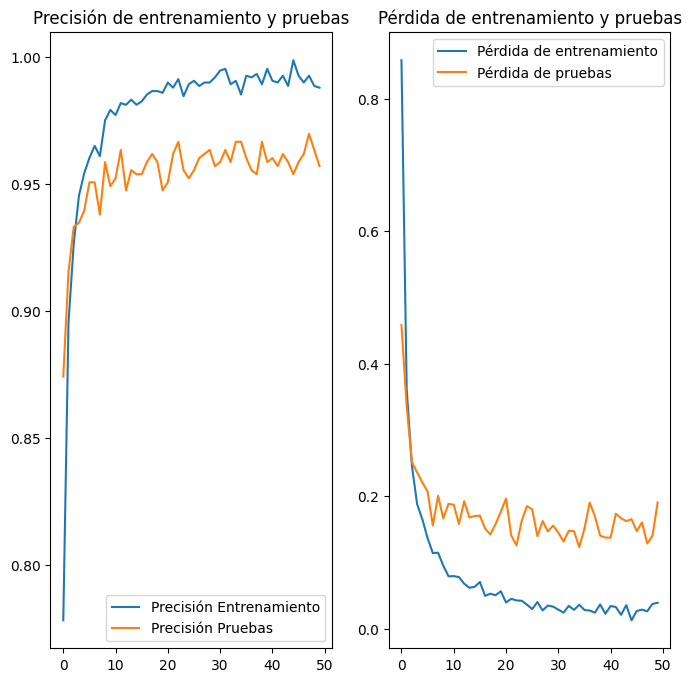

In [10]:
acc = historial.history['accuracy']

val_acc = historial.history['val_accuracy']

loss = historial.history['loss']

val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)

plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')

plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')

plt.legend(loc='lower right')

plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)

plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')

plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')

plt.legend(loc='upper right')

plt.title('Pérdida de entrenamiento y pruebas')

plt.show()


In [12]:
modelo.save('SignalClassifier.h5')

In [13]:
import tensorflow as tf
modelo = tf.keras.models.load_model('SignalClassifier.h5')
model_json = modelo.to_json()
with open("SignalClassifier.json", "w") as json_file:
    json_file.write(model_json)





In [16]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

def categorizar(url):
    # Realizar una solicitud HTTP a la URL
    respuesta = requests.get(url)

    # Abrir la imagen desde el contenido de la respuesta
    img = Image.open(BytesIO(respuesta.content))

    # Convertir la imagen a un array de numpy y normalizar
    img = np.array(img).astype(float) / 255

    # Redimensionar la imagen
    img = cv2.resize(img, (224, 224))

    # Realizar la predicción
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))

    # Devolver la clase con la mayor probabilidad
    return np.argmax(prediccion[0], axis=-1)


In [54]:
names = ["Transmetro","PuntoE","NoParquing","Stop","NoReturn","ElectDetentionSTOP","LetPass","NoTRight","NoTLeft","ElectDetention","AnimalAbuse","SquaredElecDet","Bikes","Peaton","ScolarZone"]
#

url = Input("Link de señal:")
prediccion = categorizar(url)
print(names[prediccion])

InvalidSchema: No connection adapters were found for 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAOEAAADhCAMAAAAJbSJIAAAAxlBMVEX////9yAAdHRvR0dEAABz/zADouAYSFhv8/Pz/xwD/ywDO0trZ2dnZrAkPFRsLExv+56jmzYry8vLp6eng4OD/0QAADRvTpwzFnAxxXBUXGRv5xQAZGht2YBUACBwDDxz+34vxvwT/+/D/+ef91V7+6rRCOBnKoA2siRBnVBaSdRMABRybfBJHPBjfsQhOQRi6lA6JbhRaShcyLBohIBqlhBBiUBfjzpTW0L3zyk3U0MXrzHIpJhqMcRP/1wA5MRmAaBTs5tQ7h9YUAAALZUlEQVR4nO2da3vaOBOGayIBVgJsDzIBA47bJhBI0pxodrftG/b//6nXsi3b2LKtk8H2xfNhd3sVWO48M6ORRpAPH0466aSTTjrppJNOOumkk0466aSTTkrr6/XV1dX112O/jcr07btpGoZhmt+/HfutVKNr08T2eDm2sWleH/vNVKG/TOjOAdHcheZfx347+uUBDixnASywcKxBCxEJIOiBlYvclffv9iEGgKMu9CoN7I7ahxgADn1AgjhsG+I+YAsRkyFKEVsVqAGglQAkiFZ7ELMOtszFdA7GiC3JxTzA1iCyQ7RFgcoqMq0qN0UOtsLF/BxsSS6WAzYcsSxEGx+oxUWmBeWGz8EGu8iTg43ORRHARiLyh2hDA5W3yCQRG1VuRB1snItiORgjNiYX5QAbhCgTohSxEYEqXmSSiA0oN/IONsRF2RyMEWuei6qAtUdUC1GKWONAVSkyScTalhsdDtbaRfUcjBFrmYv6AGuKyBGiEGIMESdi7QK1vMhAezV/fn5aYi7G2pWbcgfxFmxGvZ4DXgZccVwzFzkOfiegE2gKHjkRa5SL5YB4TQE9gQfOQK0NYnmIom4CsNO7wTyE9QlUjk4GPjkJwg4Y8FbUWpQbnk4Gvk+ThNYd56JZCxe5FnqUDNJOZzTnP2Q8ei7ydTJpwgl343N0RM5mG/6e7UXpWuQc9aiByj1dmo/2Ks2Sr9KEiEcsN9zbJTRIhunst1B3fkQXBXYTeLKQtNA4Yi4KbZfQfYQI7vgW/KMjCu7o0Rw4086st9g8igIeKVCFz2Tww9ONNX3e2t4zEPY2i2KIBy83EmcyyNsAky2wh3c5AS+PqNaTKekjC4jtx1sAht4mqndn8+2GQ8SD5qIkoI+38fCCRWMBdl1+xoMiyh4beu5thsml3wG3A1zDQbjkwS/8A/bwfA3B/SUv48HKjayDLsjwEU3B68rgvbFxEBdliwz+4zAJSUIu1i5XQh4kF6WraI6F4W4DzB94GA+AKD2bgH8sBli89R+B5yXHi1YeqPLTJXuRBXRWP0C8repxncFVXG4ULiGsGRY66/8N5sCiu2O+jXGlLioMX2xWFs4cr0N176YgCNbZC1dPXmEuKgAyLex0NivvtSB6vAkYj31UrDIAZVrorYXvvmsQD/zjRt5TxooCVemezB3TQs+1ceAaXi1iYB7ECsqN0gibVUh9DW9DpsBkzjCtxEWlCS+8CwmnGUTgBg/Bk5FAmFaQi2ojbDtcEKb3GUInXCHQEoiEqXZEtVsWOLRwtrAn6d3FbBTGJXwlPwXQFdgvagxUlSKDIH4YBRaCJV5mauomnJcG6wl/mGotN/IOIgjH698gBFzj9PE+CcxwmBiMGAXCVKOL0hdisXG56wEnZBo9Y+ayQYeJ+MdULEy15aIcoNeNPd5aYBRZNpvZRnoY7Gs4CWyDjxsSpluxEzgNiHIhCsc/UkcyILiCgZ97GRPd4Dn+kji9Fzov1hCockUGjcEeyGwIttSpjIm0umAyoPKacSEplxvJIoNvYsCpswGvk1X0VQOZRJz1wiWRDKhGPwTP/BVdlC4y/uLmWWcBcP/nsQvj4zSYPa6hF2zwFoDfIpUmRFTIRfmT7Yln/AbMbrdjO3WVDT1kwpQuGAa0HzjvvWlCVOhk7N39zrcu+4bxfaY7jW+fiPMZCoGqdOPXg8uxI1gV9jSaiw/c9hGlyo2uG78Z2RnCaMGQlZSL1xovxO4L719bSC4Y0qK5KPD1Wt8qA0xdWwgXDKkETIgi8n9J2nfTtaoIUYPZuXHfdMsXCVTLNb/zAn418dxZVAJo4J/ZERQ9r1EQ7AJnjk3eb/O7Nm2wWFUCiLJ7RMEtRY7gagFs7ky8MsZAtcDlvZGX7GnN9F3HD9MFYGxccRMugaX+Y2UIrhgWOsppSIQssBQgrMpD20rv8j0LRdtttoQ8rCwP8RPrbBjosFAsD/1aCvTXUtZK0RE4CS6QYC2taj3Ez9mVokMO3DQsFsF62O9zElbT00DWStHR0LVFPc1/n7gRK+lL91aKWVxyovGF9AuHgG9fPvMjVrC3gNuEhdPf7/FB3IvqhzKDvcXH8wuCyEmo6ROhSSX3TVPLXcfnGcBWeV26P/x4fnZxwW9i/5NuF/EuRppZD3gcO6rUeccOnp2d8ZvY73/6/FFrLiZPaGbk+BTFS6PK2ktz0AckiJwm9vufv5xrRUwcBvuABo4nUc6T9P8iBchvomfhl4sQUUugwstEUI7JCyZObHrSfdteiIoTnoWIOsoNisdOILz9lLi/MJTMw0SRoYQXQoRn2lyE28gwcBkalohbyQ1ixkGCKEZ4pisX3RgwuqwPt/FHFC5lCNM5KOOhLkQ4dzKAyT5cbKpWACiQh/2QUE+gImohWCVqStzFDfk/zpYAzIaoEOGnkFBHuUF0dadTtvA9Rm0N5522fcB0kRFbD+Mw1eEinW5b6z0QFLc1wn0b20GBnsZvai72EeVzEd9MmRwwGoOL9m3MHCR1htvC0ERNiOHKlzmQiT+YuOH7lH45oMDeos9AzAlUBIsUdy9kp5t4LDJQ1Nb4l6PYz2YCskP0QmR/yEZklhv0cDvJ1w4acDeioYgG0WNvyRpIE7H3jA34lH32bZcJyC4ygoD8LqIBGOYKeE01nXp3vP9cR49deDv7uK2xPMJd9nVYzY4mB2PEs7JcZEyTYoElovsm8il1nPho/sI/AqSPcxN/SDw9S1iYg2KAvIjFhHF3RqpJ8mMXBD5qa8gfxoypVIZQKyAbMROoHqGVJ+DlF/4ZhKK3VsBV4qEg6eliS/Czz08TagzRfMRMuUG4QN7fBxb6awVM/hVM3HEf7cimOKsMoKYiI+hioeg8jXkqGkX4lOsbT7Q7mIcotPTT7pPdtsBO2NbwDC8056AuRNqyOUyT6FrJM7yoCFA5UN14rWAI0fOb8uFFJSGaj8i9maItW17nSU9rSocXFRQZPS7S7jpv4kpvLpQNLyp0MA+RMxfhdBatFcy/DzuZki8EqSwHlRFpy5YfhLTNKdwEVw4oH6hwaxWsFUTR9rjgUk3FIZqPyFFuwt0D2VfkvfvwiKNgeFFpkSlG5HCxcK0gom1N/vDiIA7mIZZ+CVbYshWdUuCyWlR9Diog0tWw6HYODAaLs5zhxQEBZQI1LKXD54LFLvQ5J1UPFqL5iMXlBu/AdMY8jEjI6pGhIrPSHKjIFCMWu4hXN68/S76T7+EdgFfm1ysd2ME8xJLf6IRh2TdCINjtMg8OD5qD8og8QsyfwVEAdez6eXWEEM1H1HnvJgY8cJEpRtx3EcmqDg7mIe7l4lhWScCj5CAnogtk5dYEsCxQc74Ho1zRHvGoIZqPGJUbZcIjFpliROqiapTWwME8xDAX7UtZ2bXIQQ5EpdWiNoBVdTc1CdF8RF2/Z6YWgFW4WCsH8xB1/L6n2gDqRqwhoN5ArV2I5iOq/e68mgHqc7GmDuYhyv8OyxoC6kGsNaCOQK1xiAZSLTe1LTKx1FysvYNEKrlY8xykkkdsCKDCILwJIRpIrtw0oMjEknGxQQ4SSUymmpKDVKKIjQMUDdSGhWggkXLTqCITi9/FRjpIxJuLDcxBKj7EBgPyBWpjQzRQeblpaJGJVeZiwx0kKs7FRucgVRFiKwCLArUFIRqIhQhWLnJXoB2ALETLWQALLByrHYAMRHfuT+vnbksA04hvpoHt8XJsY8N8awdgGvHvf0wTIWSa//zdFsAU4tn5v2+/fv16+3efr9GAaUQP8jyF13TALGJGTQcsRWw+YAliGwALEdsBWIDYFsBcxPYA5iC2CTD1TSltBGQgtg0wQrygfK0DDBA/fyGQFz5f6wB9RJ+RyONrHyBB9BgJJflnv4WAH3zGSMd+L5Wp5XgnnSSh/wPO8q00hukfYQAAAABJRU5ErkJggg=='